In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import t

In [18]:
# Load the Excel file
file_path = './Grupo_3.xlsx'

# Load the sheet names
xls = pd.ExcelFile(file_path)
print(xls.sheet_names)  # This will show the available sheet names

# Load each sheet into a separate DataFrame
dfSantaAna = pd.read_excel(xls, sheet_name=xls.sheet_names[0])
dfLaFloresta = pd.read_excel(xls, sheet_name=xls.sheet_names[1])

# Optional: Show the first few rows of each DataFrame
print(dfSantaAna.head())
print(dfLaFloresta.head())

['Santa Ana', 'La Floresta']
       Fecha        Ventas
0 2023-01-01  12622.120347
1 2023-01-02  19769.873469
2 2023-01-03  20177.671875
3 2023-01-04  17454.600891
4 2023-01-05  17672.242987
       Fecha        Ventas
0 2023-01-01  14767.536664
1 2023-01-02  13889.323232
2 2023-01-03  11491.085327
3 2023-01-04  18903.512075
4 2023-01-05  13703.219431


## 1) (3.5 puntos) Determinen funciones empíricas de distribución para las ventas en ambas tiendas durante cada uno de los meses del año. Determinen tabién aproximaciones a las funciones de densidad para las distribuciones anteriores.
## Determine intervalos de confianza empíricos para cada mes, para significancias del 95 % y el 99 %.

In [19]:
#Función para agrupar las ventas por mes
def ventas_por_mes(df):
    df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')
    df['mes'] = df['Fecha'].dt.month
    return df

In [20]:
dfLaFloresta_mensual = ventas_por_mes(dfLaFloresta)
dfSantaAna_mensual = ventas_por_mes(dfSantaAna) 

In [21]:
#Funcion para graficar las ventas por mes de acuerdo a la funcion requerida
def plot_por_mes(df1, tienda1, df2, tienda2, plot_type='kde'):
    # Ver que tengan las columnas requeridas
    required_columns = ['mes', 'Ventas']
    if not all(col in df1.columns for col in required_columns) or not all(col in df2.columns for col in required_columns):
        raise ValueError("Both DataFrames must have 'mes' and 'Ventas' columns")
    
    meses = df1['mes'].unique()
    meses = sorted(meses)
    
    plt.figure(figsize=(15, 10))
    
    # reducimos la notación de los valores para no comprimir el gráfico (e.g., 1000 -> 1K)
    def thousands_formatter(x, pos):
        if x >= 1000:
            return f'{int(x/1000)}K'
        return f'{int(x)}'
    
    for i, mes in enumerate(meses, 1):
        ventas1_mes = df1[df1['mes'] == mes]['Ventas'].dropna()
        ventas2_mes = df2[df2['mes'] == mes]['Ventas'].dropna()
        
        if len(ventas1_mes) == 0 and len(ventas2_mes) == 0:
            continue  # Verificar que haya datos para el mes
        
        plt.subplot(3, 4, i)
        
        if plot_type == 'kde':
            sns.kdeplot(ventas1_mes, color='blue', fill=True, label=tienda1 if i == 1 else None)
            sns.kdeplot(ventas2_mes, color='orange', fill=True, label=tienda2 if i == 1 else None)
        elif plot_type == 'ecdf':
            # Calcular la ECDF
            sns.ecdfplot(data=ventas1_mes, color='blue', label=tienda1 if i == 1 else None)
            sns.ecdfplot(data=ventas2_mes, color='orange', label=tienda2 if i == 1 else None)   
        elif plot_type == 'densidad':
            sns.histplot(ventas1_mes, color='blue', alpha=1, label=tienda1 if i == 1 else None)
            sns.histplot(ventas2_mes, color='orange', alpha=0.3, label=tienda2 if i == 1 else None)
        else:
            raise ValueError("Invalid plot type. Choose 'kde', 'ecdf', or 'densidad'.")
        
        
        plt.title(f'Mes {mes}')
        plt.xlabel('Ventas')
        plt.ylabel('F(x)')
        plt.grid(True)
        
        # Convertir el eje X con la reducción de miles 
        plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
        # setear el número máximo de ticks en el eje X
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
        # setear el número máximo de ticks en el eje Y
        plt.xticks(rotation=45, fontsize=8)
    
    plt.tight_layout(pad=3.0)
    # Agregar título general del gráfico
    plt.figlegend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        fontsize=12,
        title=f"{tienda1} vs {tienda2} ",
        title_fontsize=14,
        frameon=True,
        edgecolor='black'
    )
    plt.show()

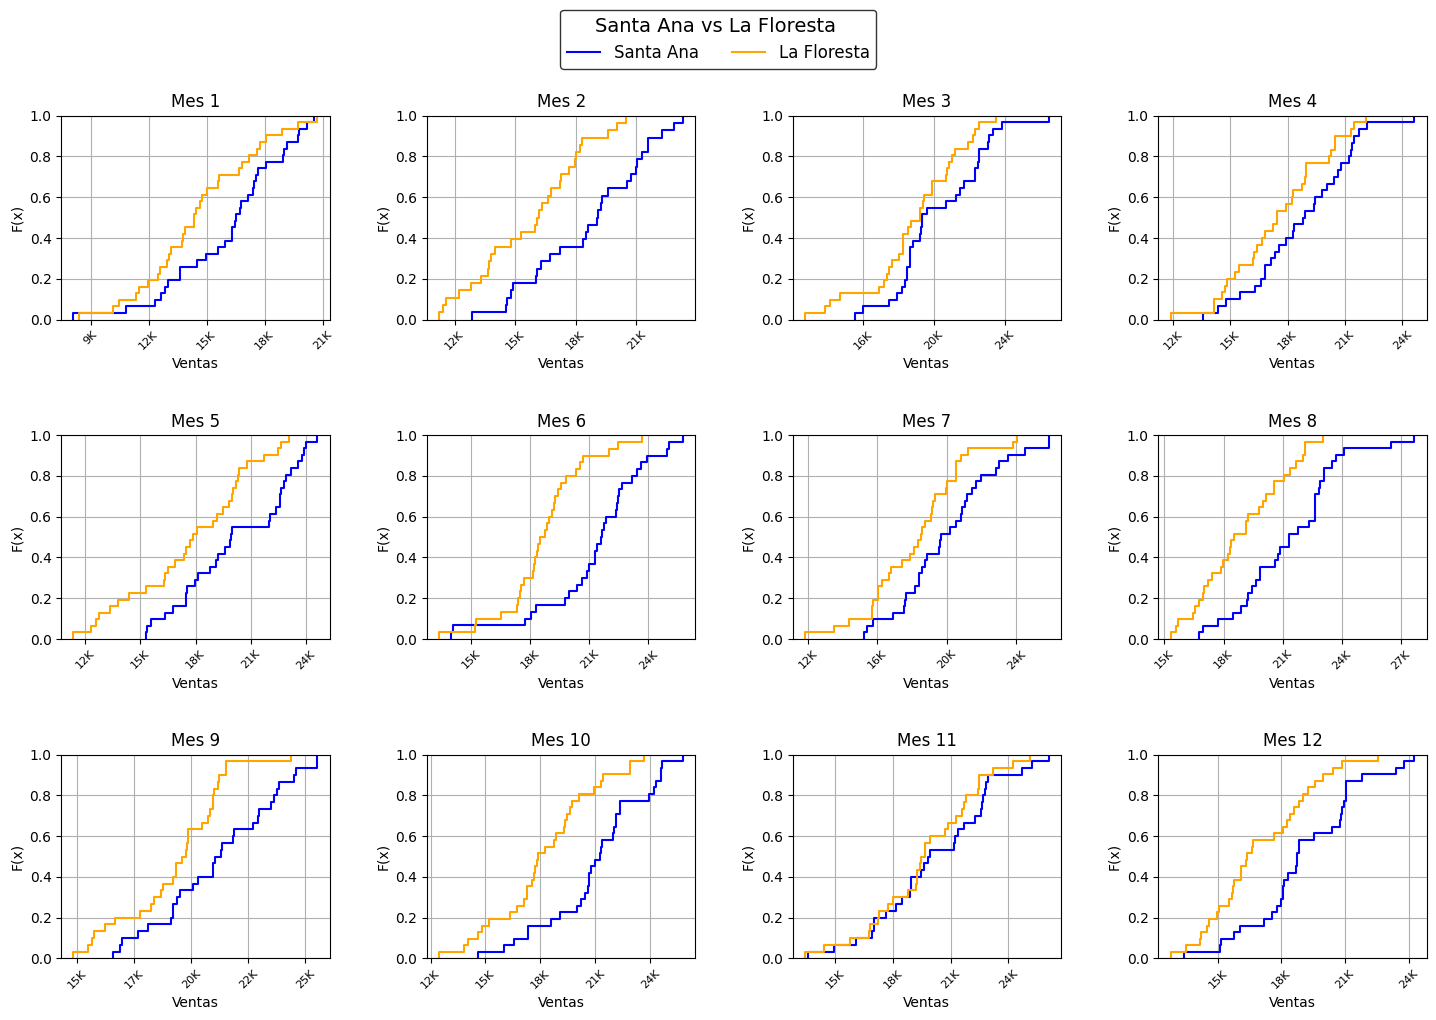

In [22]:
plot_por_mes(dfSantaAna_mensual, 'Santa Ana', dfLaFloresta_mensual, 'La Floresta', 'ecdf')

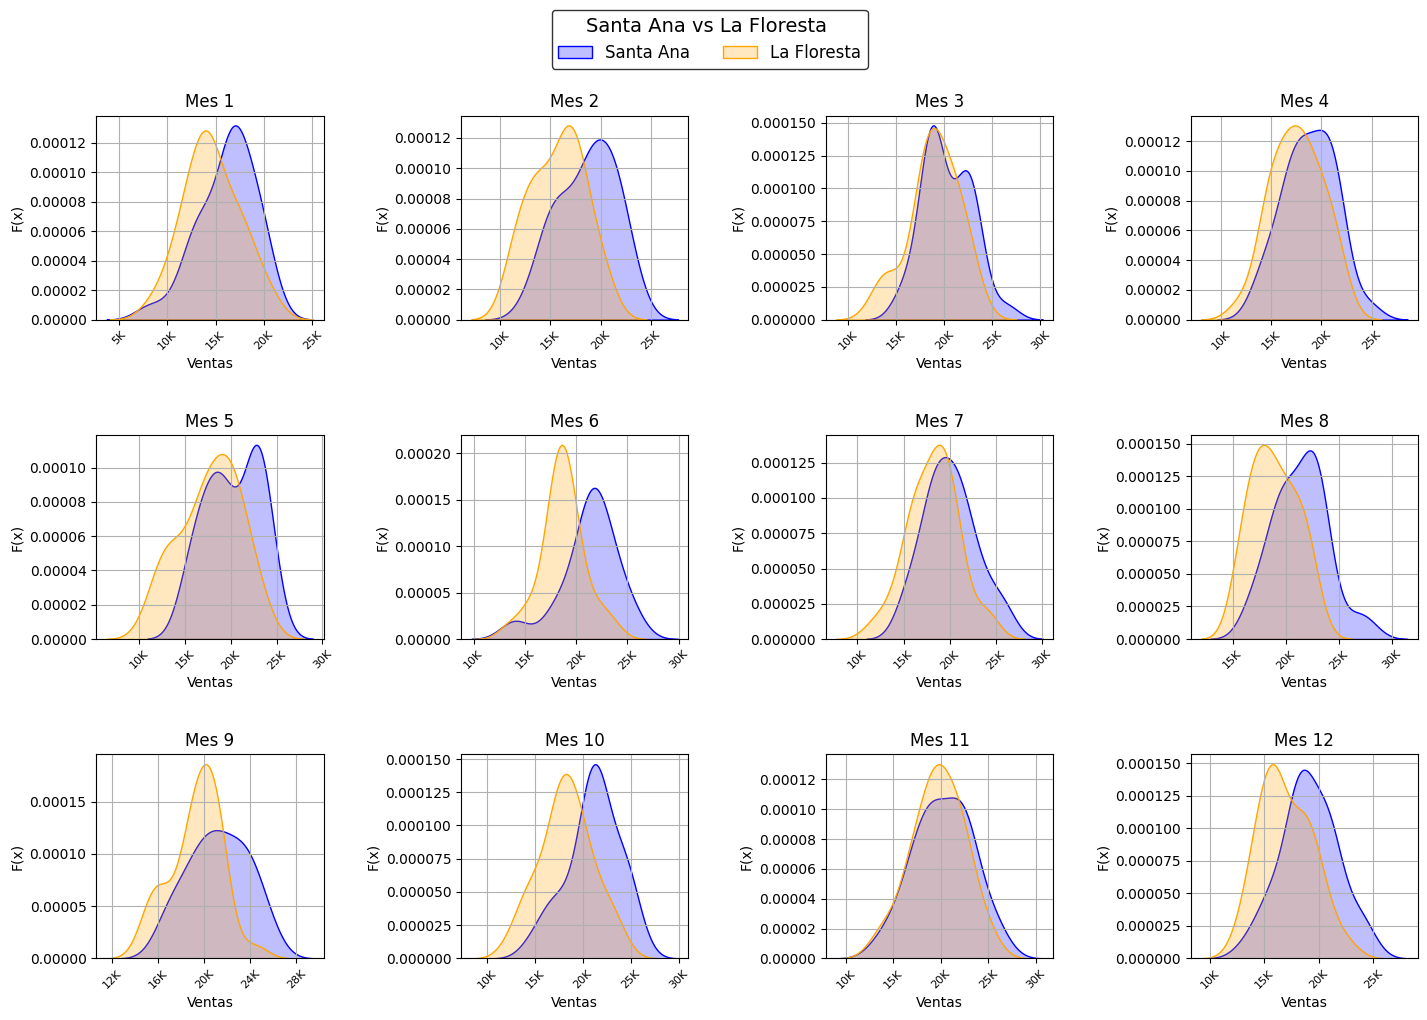

In [23]:
plot_por_mes(dfSantaAna_mensual, 'Santa Ana', dfLaFloresta_mensual, 'La Floresta', 'kde')

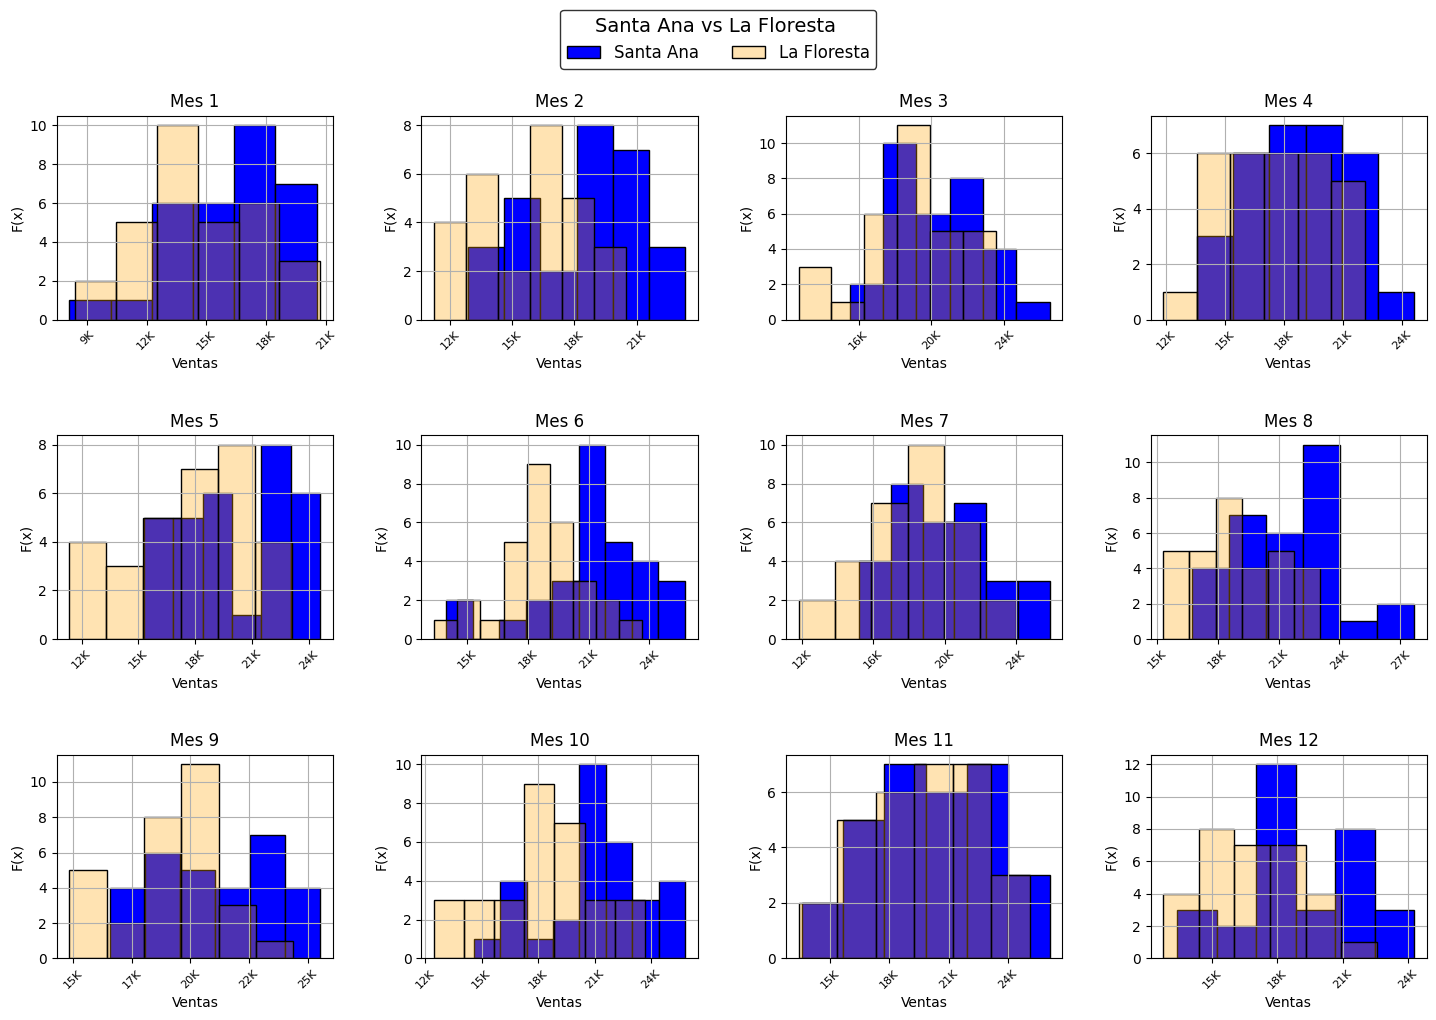

In [24]:
plot_por_mes(dfSantaAna_mensual, 'Santa Ana', dfLaFloresta_mensual, 'La Floresta', 'densidad')

In [25]:
def plot_tsudent_por_mes(df, tienda):
    meses = df['mes'].unique()
    meses = sorted(meses)

    for i, mes in enumerate(meses, 1):
        ventas_mes = df[df['mes'] == mes]['Ventas'].dropna()
        n = len(ventas_mes)
        media = np.mean(ventas_mes)
        desv = np.std(ventas_mes, ddof=1)
        # Intervalo de confianza al 95%
        alpha = 0.05
        t_crit_95 = t.ppf(1 - alpha/2, df=n-1)
        margen_error_95 = t_crit_95 * (desv / np.sqrt(n))
        ic_95 = (media - margen_error_95, media + margen_error_95)
        print(f"Intervalo de confianza al 95% para {tienda} - Mes {mes}: {ic_95}")
        # Intervalo de confianza al 99%
        alpha = 0.01
        t_crit_99 = t.ppf(1 - alpha/2, df=n-1)
        margen_error_99 = t_crit_99 * (desv / np.sqrt(n))
        ic_99 = (media - margen_error_99, media + margen_error_99)
        print(f"Intervalo de confianza al 99% para {tienda} - Mes {mes}: {ic_99}")

In [26]:
def get_tsudent_por_mes(df, tienda):
    meses = df['mes'].unique()
    meses = sorted(meses)
    
    dist_95 = []
    dist_99 = []
    
    for mes in meses:
        ventas_mes = df[df['mes'] == mes]['Ventas'].dropna()
        n = len(ventas_mes)
        media = float(np.mean(ventas_mes))  # Convert to Python float
        desv = float(np.std(ventas_mes, ddof=1))  # Convert to Python float
        
        # Intervalo de confianza al 95%
        alpha_95 = 0.05
        t_crit_95 = t.ppf(1 - alpha_95/2, df=n-1)
        margen_error_95 = t_crit_95 * (desv / np.sqrt(n))
        lower_95 = float(media - margen_error_95)  # Convert to Python float
        upper_95 = float(media + margen_error_95)  # Convert to Python float
        dist_95.append([tienda, int(mes), media, lower_95, upper_95])  # Convert mes to int
        
        # Intervalo de confianza al 99%
        alpha_99 = 0.01
        t_crit_99 = t.ppf(1 - alpha_99/2, df=n-1)
        margen_error_99 = t_crit_99 * (desv / np.sqrt(n))
        lower_99 = float(media - margen_error_99)  # Convert to Python float
        upper_99 = float(media + margen_error_99)  # Convert to Python float
        dist_99.append([tienda, int(mes), media, lower_99, upper_99])  # Convert mes to int
    
    return dist_95, dist_99

In [27]:
SantaAna_95, SantaAna_99 = get_tsudent_por_mes(dfSantaAna, 'Santa Ana')
LaFloresta_95, LaFloresta_99 = get_tsudent_por_mes(dfLaFloresta, 'La Floresta')

In [28]:
def imprimir_intervalos_confianza(dist_95, dist_99, frecuencia, tienda):
    # Create DataFrames from dist_95 and dist_99
    columns = ['Tienda', frecuencia, 'Media', 'Límite Inferior', 'Límite Superior']
    df_95 = pd.DataFrame(dist_95, columns=columns)
    df_99 = pd.DataFrame(dist_99, columns=columns)
    
    # Rename columns to distinguish 95% and 99% intervals
    df_95 = df_95.rename(columns={
        'Límite Inferior': 'Límite Inferior (95%)',
        'Límite Superior': 'Límite Superior (95%)'
    })
    df_99 = df_99.rename(columns={
        'Límite Inferior': 'Límite Inferior (99%)',
        'Límite Superior': 'Límite Superior (99%)'
    })
    
    # Merge DataFrames on Tienda and frecuencia (Mes)
    df_merged = pd.merge(
        df_95,
        df_99[[frecuencia, 'Límite Inferior (99%)', 'Límite Superior (99%)']],
        on=frecuencia,
        how='inner'
    )
    
    # Verify consistency of Tienda and Media
    if not (df_merged['Tienda'] == tienda).all():
        raise ValueError("Inconsistent Tienda values in merged DataFrame")
    
    # Ensure Tienda column is set
    df_merged['Tienda'] = tienda
    
    # Reorder columns for clarity
    final_columns = [
        'Tienda',
        frecuencia,
        'Media',
        'Límite Inferior (95%)',
        'Límite Superior (95%)',
        'Límite Inferior (99%)',
        'Límite Superior (99%)'
    ]
    df_merged = df_merged[final_columns]
    
    return df_merged

In [29]:
imprimir_intervalos_confianza(SantaAna_95, SantaAna_99, 'mes', 'Santa Ana')

,Tienda,mes,Media,Límite Inferior (95%),Límite Superior (95%),Límite Inferior (99%),Límite Superior (99%)
0,Santa Ana,1,16122.899357,15049.024706,17196.774009,14676.887286,17568.911428
1,Santa Ana,2,18649.163506,17546.930740,19751.396273,17160.766917,20137.560095
2,Santa Ana,3,20288.813455,19372.550914,21205.075996,19055.031940,21522.594971
3,Santa Ana,4,18772.741568,17806.619944,19738.863191,17470.685325,20074.797811
4,Santa Ana,5,20228.809364,19160.565493,21297.053234,18790.379348,21667.239379
5,Santa Ana,6,21249.626002,20222.590186,22276.661818,19865.474810,22633.777193
6,Santa Ana,7,20041.211660,19014.696759,21067.726562,18658.971250,21423.452071
7,Santa Ana,8,21382.439982,20454.230580,22310.649384,20132.571575,22632.308389
8,Santa Ana,9,21194.077173,20225.892210,22162.262137,19889.240137,22498.914210
9,Santa Ana,10,21059.617872,20053.115017,22066.120727,19704.324426,22414.911319


In [30]:
#Metodo alternativo para imprimir los intervalos de confianza en forma de tabla:
from tabulate import tabulate
def imprimir_intervalos_confianza_2(intervalo_95, intervalo_99, frecuencia, tienda):
    # Combine the two intervals into a single list
    intervalos = []
    for row_95, row_99 in zip(intervalo_95, intervalo_99):
        # aseguramos que los valores de tienda y mes coincidan
        assert row_95[0] == row_99[0] and row_95[1] == row_99[1], "Mismatch in tienda or mes"
        # creamos la fila combinada
        combined_row = [
            row_95[0],  # Tienda
            row_95[1],  # Mes
            row_95[2],  # Media
            row_95[3],  # Lower 95%
            row_95[4],  # Upper 95%
            row_99[3],  # Lower 99%
            row_99[4]   # Upper 99%
        ]
        intervalos.append(combined_row)
    headers = ["Tienda", frecuencia, "Media", "Límite Inferior (95%)", "Límite Superior (95%)", "Límite Inferior (99%)", "Límite Superior (99%)"]
    # Print table
    print(tabulate(intervalos, headers=headers, tablefmt="grid", floatfmt=".4f"))

In [31]:
imprimir_intervalos_confianza_2(SantaAna_95, SantaAna_99, 'Mes', 'Santa Ana')

+-----------+-------+------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Tienda    |   Mes |      Media |   Límite Inferior (95%) |   Límite Superior (95%) |   Límite Inferior (99%) |   Límite Superior (99%) |
+===========+=======+============+=========================+=========================+=========================+=========================+
| Santa Ana |     1 | 16122.8994 |              15049.0247 |              17196.7740 |              14676.8873 |              17568.9114 |
+-----------+-------+------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Santa Ana |     2 | 18649.1635 |              17546.9307 |              19751.3963 |              17160.7669 |              20137.5601 |
+-----------+-------+------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Santa Ana |     3 | 20288

In [32]:
# imprimir_intervalos_confianza_2(LaFloresta_95, LaFloresta_99, 'La Floresta')

## 2) (3.5 puntos) Determine funciones empíricas de distribución para las ventas en ambas tiendas por cada día de la semana. Establezcan aproximaciones a las funciones de densidad para las distribuciones anteriores. Establezcan también intervalos de confianza empíricos para cada día de la semana, para significancias del 95 % y el 99 %.

In [33]:
#Función para agrupar las ventas por día
def ventas_por_dia(df):
    df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')
    df['DayOfWeek'] = df['Fecha'].dt.day_name()
    return df

In [34]:
dfSantaAna_diario = ventas_por_dia(dfSantaAna)
dfLaFloresta_diario = ventas_por_dia(dfLaFloresta)
#Función para graficar las ventas por día de acuerdo a la función requerida

In [35]:
dfLaFloresta_diario

,Fecha,Ventas,mes,DayOfWeek
0,2023-01-01,14767.536664,1,Sunday
1,2023-01-02,13889.323232,1,Monday
2,2023-01-03,11491.085327,1,Tuesday
3,2023-01-04,18903.512075,1,Wednesday
4,2023-01-05,13703.219431,1,Thursday
...,...,...,...,...
360,2023-12-27,15757.734800,12,Wednesday
361,2023-12-28,16625.746643,12,Thursday
362,2023-12-29,19025.415563,12,Friday
363,2023-12-30,15517.542208,12,Saturday


In [36]:
#Funcion para graficar las ventas por mes de acuerdo a la funcion requerida
def plot_por_dia(df1, tienda1, df2, tienda2, plot_type='kde'):
    # Ver que tengan las columnas requeridas
    required_columns = ['DayOfWeek', 'Ventas']
    if not all(col in df1.columns for col in required_columns) or not all(col in df2.columns for col in required_columns):
        raise ValueError("Both DataFrames must have 'mes' and 'Ventas' columns")
    
    dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    #dias = sorted(dias)
        # Map days to Spanish for output
    day_map = {
        'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
        'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
    }
    plt.figure(figsize=(15, 10))
    
    # reducimos la notación de los valores para no comprimir el gráfico (e.g., 1000 -> 1K)
    def thousands_formatter(x, pos):
        if x >= 1000:
            return f'{int(x/1000)}K'
        return f'{int(x)}'
    
    for i, dia in enumerate(dias, 1):
        ventas1_dia = df1[df1['DayOfWeek'] == dia]['Ventas'].dropna()
        ventas2_dia = df2[df2['DayOfWeek'] == dia]['Ventas'].dropna()
        
        if len(ventas1_dia) == 0 and len(ventas2_dia) == 0:
            continue  # Verificar que haya datos para el mes
        
        plt.subplot(3, 4, i)
        
        if plot_type == 'kde':
            sns.kdeplot(ventas1_dia, color='blue', fill=True, label=tienda1 if i == 1 else None)
            sns.kdeplot(ventas2_dia, color='orange', fill=True, label=tienda2 if i == 1 else None)
        elif plot_type == 'ecdf':
            # Calcular la ECDF
            sns.ecdfplot(data=ventas1_dia, color='blue', label=tienda1 if i == 1 else None)
            sns.ecdfplot(data=ventas2_dia, color='orange', label=tienda2 if i == 1 else None)   
        elif plot_type == 'densidad':
            sns.histplot(ventas1_dia, color='blue', alpha=1, label=tienda1 if i == 1 else None)
            sns.histplot(ventas2_dia, color='orange', alpha=0.3, label=tienda2 if i == 1 else None)
        else:
            raise ValueError("Invalid plot type. Choose 'kde', 'ecdf', or 'densidad'.")
        
        
        plt.title(f'{day_map[dia]}')
        plt.xlabel('Ventas')
        plt.ylabel('F(x)')
        plt.grid(True)
        
        # Convertir el eje X con la reducción de miles 
        plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
        # setear el número máximo de ticks en el eje X
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
        # setear el número máximo de ticks en el eje Y
        plt.xticks(rotation=45, fontsize=8)
    
    plt.tight_layout(pad=3.0)
    # Agregar título general del gráfico
    plt.figlegend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        fontsize=12,
        title=f"{tienda1} vs {tienda2} ",
        title_fontsize=14,
        frameon=True,
        edgecolor='black'
    )
    plt.show()

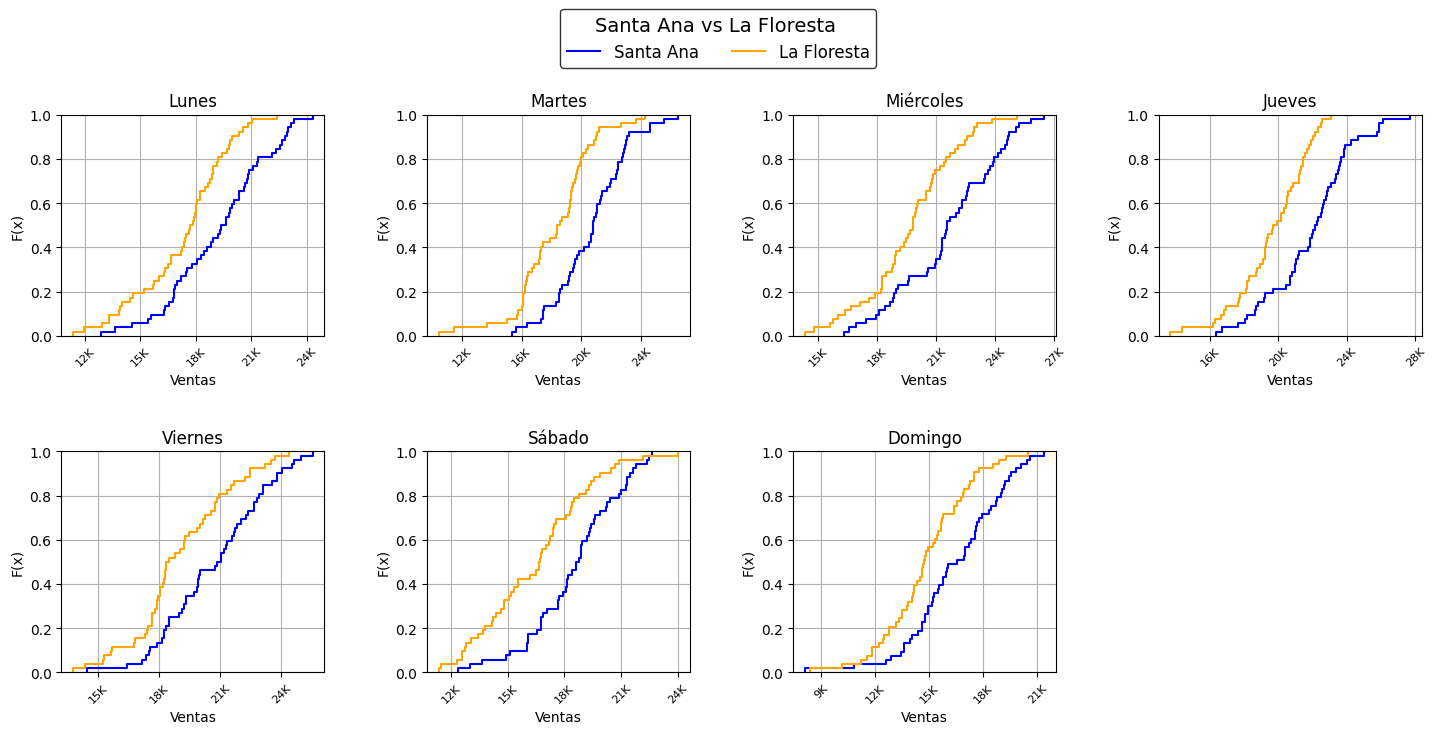

In [37]:
plot_por_dia(dfSantaAna_diario, 'Santa Ana', dfLaFloresta_diario, 'La Floresta', 'ecdf')

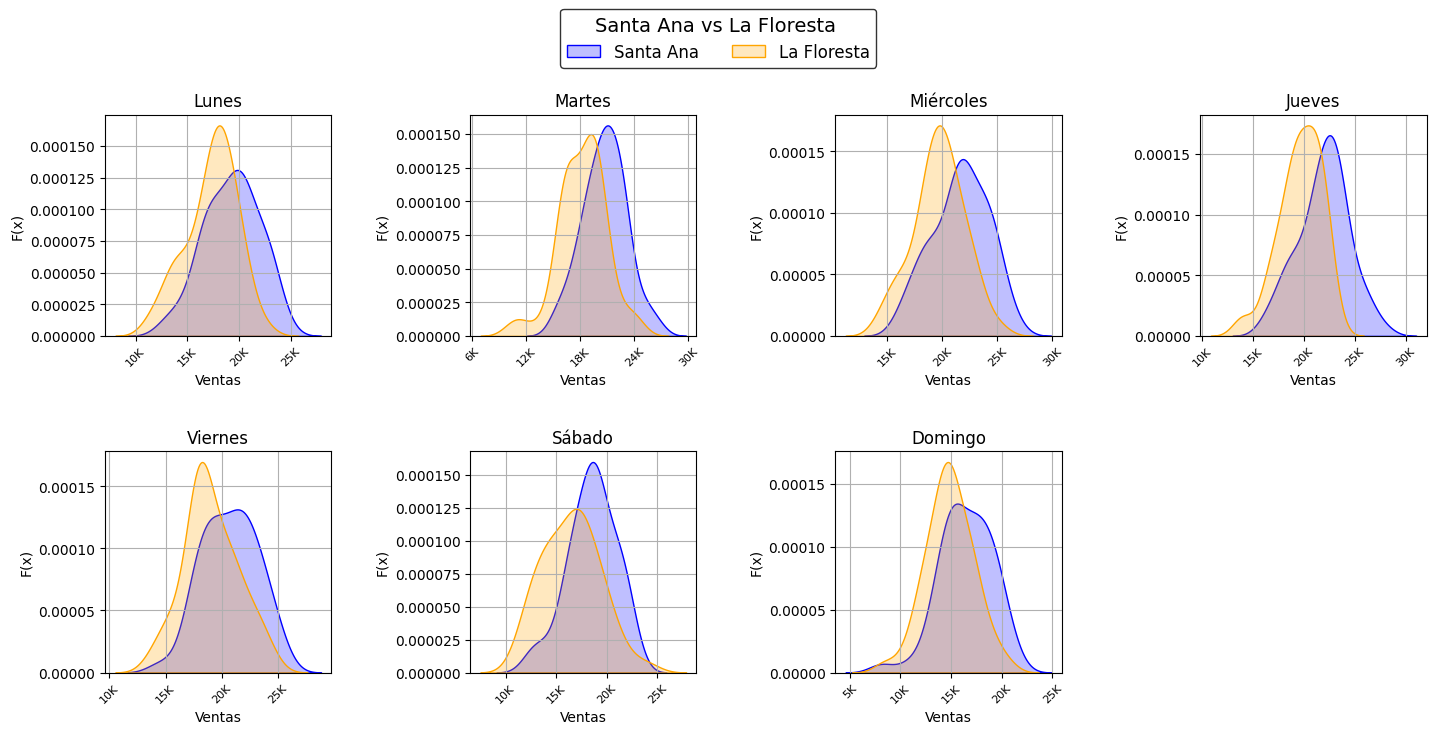

In [38]:
plot_por_dia(dfSantaAna_diario, 'Santa Ana', dfLaFloresta_diario, 'La Floresta', 'kde')

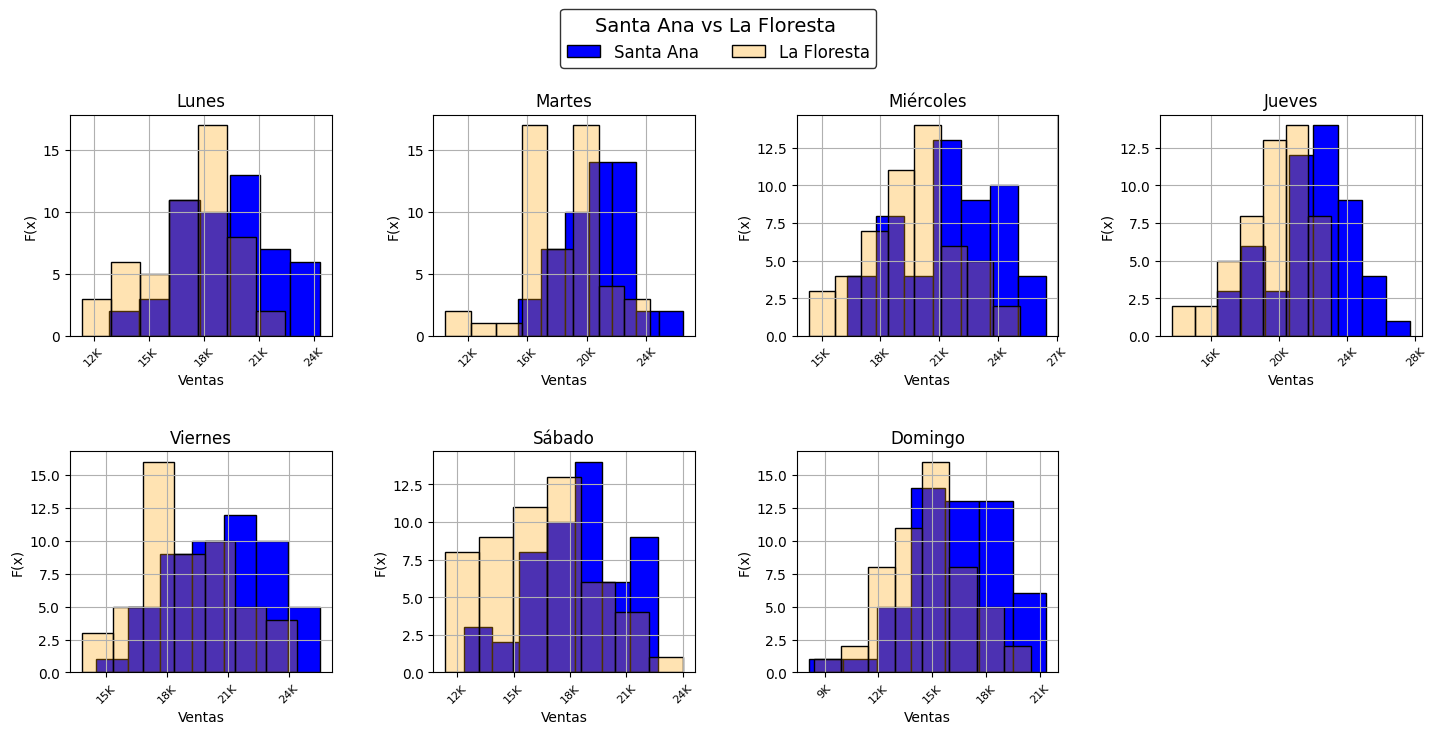

In [39]:
plot_por_dia(dfSantaAna_diario, 'Santa Ana', dfLaFloresta_diario, 'La Floresta', 'densidad')

In [40]:
def get_tsudent_por_dia(df, tienda):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dias = pd.DataFrame(days, columns=['DayOfWeek'])
    dias = dias['DayOfWeek'].unique()   
    #dias = sorted(dias)
    
    dist_95 = []
    dist_99 = []
    
    for dia in dias:
        ventas_dia = df[df['DayOfWeek'] == dia]['Ventas'].dropna()
        n = len(ventas_dia)
        media = float(np.mean(ventas_dia))  # Convert to Python float
        desv = float(np.std(ventas_dia, ddof=1))  # Convert to Python float
        
        # Intervalo de confianza al 95%
        alpha_95 = 0.05
        t_crit_95 = t.ppf(1 - alpha_95/2, df=n-1)
        margen_error_95 = t_crit_95 * (desv / np.sqrt(n))
        lower_95 = float(media - margen_error_95)  # Convert to Python float
        upper_95 = float(media + margen_error_95)  # Convert to Python float
        dist_95.append([tienda, dia, media, lower_95, upper_95])  # Convert mes to int
        
        # Intervalo de confianza al 99%
        alpha_99 = 0.01
        t_crit_99 = t.ppf(1 - alpha_99/2, df=n-1)
        margen_error_99 = t_crit_99 * (desv / np.sqrt(n))
        lower_99 = float(media - margen_error_99)  # Convert to Python float
        upper_99 = float(media + margen_error_99)  # Convert to Python float
        dist_99.append([tienda, dia, media, lower_99, upper_99])  # Convert mes to int
    
    return dist_95, dist_99

In [41]:
SantaAna_95_diario, SantaAna_99_diario = get_tsudent_por_dia(dfSantaAna_diario, 'Santa Ana')
LaFloresta_95_diario, LaFloresta_99_diario = get_tsudent_por_dia(dfLaFloresta_diario, 'La Floresta')


In [42]:
imprimir_intervalos_confianza_2(SantaAna_95_diario, SantaAna_99_diario, 'Dia', 'Santa Ana')

+-----------+-----------+------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Tienda    | Dia       |      Media |   Límite Inferior (95%) |   Límite Superior (95%) |   Límite Inferior (99%) |   Límite Superior (99%) |
+===========+===========+============+=========================+=========================+=========================+=========================+
| Santa Ana | Monday    | 19244.7027 |              18505.9787 |              19983.4268 |              18260.1260 |              20229.2795 |
+-----------+-----------+------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Santa Ana | Tuesday   | 20658.8441 |              19991.4932 |              21326.1951 |              19769.3940 |              21548.2943 |
+-----------+-----------+------------+-------------------------+-------------------------+-------------------------+-------------------------+

In [43]:
imprimir_intervalos_confianza_2(LaFloresta_95_diario, LaFloresta_99_diario, 'Dia', 'La Floresta')

+-------------+-----------+------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Tienda      | Dia       |      Media |   Límite Inferior (95%) |   Límite Superior (95%) |   Límite Inferior (99%) |   Límite Superior (99%) |
+=============+===========+============+=========================+=========================+=========================+=========================+
| La Floresta | Monday    | 17305.4136 |              16623.6880 |              17987.1392 |              16396.8048 |              18214.0224 |
+-------------+-----------+------------+-------------------------+-------------------------+-------------------------+-------------------------+
| La Floresta | Tuesday   | 18196.3200 |              17469.4775 |              18923.1625 |              17227.5791 |              19165.0610 |
+-------------+-----------+------------+-------------------------+-------------------------+-------------------------+------------

In [44]:
imprimir_intervalos_confianza(SantaAna_95_diario, SantaAna_99_diario, 'Dia', 'Santa Ana')

,Tienda,Dia,Media,Límite Inferior (95%),Límite Superior (95%),Límite Inferior (99%),Límite Superior (99%)
0,Santa Ana,Monday,19244.702732,18505.978692,19983.426772,18260.125965,20229.279499
1,Santa Ana,Tuesday,20658.844140,19991.493221,21326.195059,19769.393987,21548.294293
2,Santa Ana,Wednesday,21598.446070,20895.511247,22301.380893,20661.569431,22535.322709
3,Santa Ana,Thursday,21924.710284,21240.111184,22609.309384,21012.271630,22837.148939
4,Santa Ana,Friday,20701.731556,20018.623189,21384.839923,19791.279762,21612.183350
5,Santa Ana,Saturday,18511.495461,17847.491121,19175.499801,17626.505653,19396.485270
6,Santa Ana,Sunday,16451.761843,15734.595723,17168.927963,15496.182032,17407.341654


## 3. (3 puntos) Realicen pruebas de hipótesis, con base en los datos, para aceptar o rechazar la intuición de Don Francisco, con significancias de 95% y 99 %.

Comenzamos realizando un análisis de ANOVA para determinar si las medias son distintas. Para esto tomamos un $\alpha$ de 0,05.
Las hipótesis son:
* $H_0$: Las medias de ventas de Santa Ana y La Floresta son iguales.
* $H_1$: Al menos una es diferente.

In [46]:
from scipy.stats import f_oneway

# f_oneway recibe los datos de los dos grupos
f_stat, p_anova = f_oneway(dfSantaAna['Ventas'], dfLaFloresta['Ventas'])
print("Estadístico F:", f_stat)
print("p-value:", p_anova)

Estadístico F: 80.29307074566687
p-value: 2.6772734947770504e-18


Como el valor de $\alpha$ es menor a 0,05, rechazamos la hipótesis nula, y las ventas son distintas.<br>
Para comprobar si efectivamente las ventas de Santa Ana son mayores que las de La Floresta, realizamos el siguiente test de hipótesis:
* $H_0$: La media de La Floresta ≥ Santa Ana
* $H_1$: La media de La Floresta < Santa Ana

In [55]:
from scipy.stats import ttest_ind

# Medias de los dos grupos
media_la_floresta = dfLaFloresta['Ventas'].mean()
media_santa_ana = dfSantaAna['Ventas'].mean()

# Imprimir medias
print("Media La Floresta:", media_la_floresta)
print("Media Santa Ana:", media_santa_ana)

# Realizar la prueba t para ver si Santa Ana tiene media mayor
t_stat, p_two_tailed = ttest_ind(dfLaFloresta['Ventas'], dfSantaAna['Ventas'], equal_var=True)

# Ajuste del valor p para prueba de una cola
# La hipótesis es que Santa Ana tiene una media mayor que La Floresta
if t_stat < 0:  # Si t_stat es positivo, Santa Ana tiene media mayor
    p_one_tailed = p_two_tailed / 2  # Cola derecha
else:  # Si t_stat es negativo, La Floresta tendría media mayor
    p_one_tailed = 1 - (p_two_tailed / 2)  # Cola izquierda

# Imprimir resultados
print("t:", t_stat)
print("p (una cola):", p_one_tailed)

# Interpretación de la prueba
if p_one_tailed < 0.05:
    print("Santa Ana tiene una media significativamente mayor que La Floresta (prueba de una cola).")
else:
    print("No hay evidencia suficiente para afirmar que Santa Ana tiene una media mayor que La Floresta.")



Media La Floresta: 17869.38272866446
Media Santa Ana: 19860.876028233622
t: -8.960640085711908
p (una cola): 1.3386367473882296e-18
Santa Ana tiene una media significativamente mayor que La Floresta (prueba de una cola).


Como $\alpha$ < 0,05, se rechaza la hipótesis nula, y Santa Ana efectivamente tiene un promedio de ventas mayor que la Floresta